---
# **Section I: Introduction to the problem/task and dataset**

### **Introduction to the Task**
The primary objective of this project is to predict the likelihood of additional goals in a soccer match based on real-time in-game statistics, with the aim of supporting decision-making in sports trading (e.g., over/under betting). By analyzing game-specific metrics, we can estimate scoring potential and influence live trading models for betting and fan engagement.

### **Dataset Overview**
This project’s dataset includes 10,000 unique snapshots of soccer matches at various timestamps, capturing the state of a game through different in-game metrics. Each snapshot includes details on the current score, possession percentages, attempts, and cards, providing a rich dataset for building predictive models.


### **Problem Motivation**
The practical application of predicting match outcomes from live data is significant for team strategy and sports betting, as knowing influential factors—such as possession and dangerous attacks—can improve decision-making and potentially impact match strategies (Kuhn & Johnson, 2013).

---


# **Section 2: Description of the dataset**

### Dataset Overview
The dataset consists of 10,000 randomly selected snapshots from soccer matches, each capturing the in-game state at a specific timestamp. Each row represents a snapshot, detailing scores, possession, and other match features, which collectively provide a momentary overview of game dynamics (Anguera et al., 2018).

### Data Collection
This dataset was collected through in-game analytics systems that continuously monitor and record essential match metrics. Although highly detailed, this collection method might introduce minor noise due to the rapid state changes inherent in live sports (Yin & Leong, 2017).

### Dataset Structure 
- **Rows**: Each row represents a single timestamp during a soccer match.
- **Columns**: Key features include:
  - **Identifier**: `uuid` - Unique identifier for each snapshot.
  - **Time**: `current_minute` - Game minute, including a 15-minute half-time, making the total match time 105 minutes.
  - **Scores**: `home_score`, `away_score`
  - **Cards**: Yellow and red cards for both teams.
  - **Gameplay Metrics**: Attacks, dangerous attacks, and shots on/off target for each team.
  - **Possession**: Ball possession percentages for each team.
  - **Target**: `final_delta` - The number of goals scored by any team. The target value for the prediction.

---


# **Section 3: List of requirements**

### Python Libraries


> Add more if may gagamitin pa


The following libraries are required to support data analysis, model training, and evaluation:
- **Data Manipulation**:
  - `pandas`: Data manipulation and cleaning (McKinney, 2011).
  - `numpy`: Numerical operations (Oliphant, 2006).
- **Data Visualization**:
  - `matplotlib`: For line and bar charts (Hunter, 2007).
  - `seaborn`: For statistical graphics (Waskom, 2021).
- **Machine Learning and Model Evaluation**:
  - `scikit-learn`: For k-NN, Linear Regression, Neural Networks, and model validation (Pedregosa et al., 2011).
  - 
- **Hyperparameter Tuning**:
  - `scikit-learn`: For grid search and random search.
- **Metrics**:
  - `scikit-learn.metrics`: 


In [54]:
# Data Manipulation
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine Learning Models
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error ,r2_score

#data cleaning and preprocessing
import numpy as np
import pandas as pd
import sklearn.preprocessing
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Data Manipulation
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine Learning Models
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error ,r2_score

from random_forest_util import tune_random_forest
from random_forest_util import print_RF
from random_forest_util import plot_learning_curve


from random_forest_util import tune_random_forest, print_RF, plot_learning_curve


plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'



In [55]:
np.random.seed(42)

# **Section 4: Data preprocessing and cleaning**

#### Cleaning Steps
- **Checking for Duplicates**: Removing redundant rows to ensure unique snapshots.
- **Type Conversion**: Ensuring all features are in suitable formats (e.g., integer for score-related features, float for percentages).
- **Handling Missing Values**: Uses techniques like imputation if necessary, based on the dataset's nature.
- **Outlier Detection**: Detects anomalies in numerical features, which may skew predictions if left unaddressed.

#### Preprocessing Techniques
Key techniques include:
- **Feature Scaling**: Since features have different units (e.g., score vs. possession percentage), scaling is essential to ensure model performance, particularly for k-NN and Neural Networks (Han et al., 2011).

### **I. Load and Inspect the Data**
- Initial Check: Start by inspecting the data types, missing values, and unique values. This helps determine what cleaning actions are necessary (Han et al., 2011).
- Data Types: Confirm the data types for each column, ensuring numerical values are correctly identified for calculations and models.


In [56]:
df = pd.read_csv('sports.csv', index_col="uuid")
df.head()

,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,away_dangerous_attacks,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,away_possession,final_delta
uuid,,,,,,,,,,,,,,,,,,,,
2f9dd904-8d9d-4aa0-a9d9-4e0f3e50d742,94,1,2,0,0,0,0,39,45,29,26,4,1,4,0,4,6,48,52,1
869c1420-9153-4d73-8d79-5db31a8a80a4,91,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,50,1
549e25a3-4c93-459d-b115-fb303273c78a,3,0,0,0,0,0,0,3,1,1,0,0,0,0,0,0,0,62,38,4
287b4be5-9163-4e2e-895d-d11052a97410,17,0,0,1,0,0,0,41,46,11,25,1,0,0,2,0,0,55,45,2
a607da6a-d6b2-4652-b7a5-6c8e4b61c2b8,76,1,0,1,0,0,0,69,78,21,46,1,1,0,3,4,4,45,55,0


In [57]:
df = df.reset_index(col_level=0)
df = df.drop('uuid', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   current_minute          7000 non-null   int64
 1   home_score              7000 non-null   int64
 2   away_score              7000 non-null   int64
 3   home_yellow_cards       7000 non-null   int64
 4   away_yellow_cards       7000 non-null   int64
 5   home_red_cards          7000 non-null   int64
 6   away_red_cards          7000 non-null   int64
 7   home_attacks            7000 non-null   int64
 8   away_attacks            7000 non-null   int64
 9   home_dangerous_attacks  7000 non-null   int64
 10  away_dangerous_attacks  7000 non-null   int64
 11  home_corners            7000 non-null   int64
 12  away_corners            7000 non-null   int64
 13  home_off_target         7000 non-null   int64
 14  away_off_target         7000 non-null   int64
 15  home_on_target       

In [58]:
# Statistical Summaries of All Feature 
df.agg(['min', 'max', 'median', 'mean']).T

,min,max,median,mean
current_minute,-348.0,583.0,70.0,59.491571
home_score,0.0,8.0,0.0,0.796000
away_score,0.0,9.0,0.0,0.623143
home_yellow_cards,0.0,8.0,0.0,0.522429
away_yellow_cards,0.0,8.0,0.0,0.603143
home_red_cards,0.0,2.0,0.0,0.009286
away_red_cards,0.0,2.0,0.0,0.015714
home_attacks,0.0,255.0,43.0,46.365429
away_attacks,0.0,183.0,41.0,43.325143
home_dangerous_attacks,0.0,134.0,25.0,27.611429


#### Check ranges of values for each feature to determine invalid / unrealistic values

### II. Remove Unrealistic Values and Outliers
- Current Minute: Limit values between 0 and 105 (including a 90-minute match plus 15 minutes for half-time).
- Yellow Cards: Set a threshold of 5 yellow cards per team, as higher values are rare.
Attacks and Dangerous Attacks: Apply upper bounds of 150 for attacks and 100 for dangerous attacks, considering typical gameplay stats.
`may citation ba 2 / src?`

- Possession Percentages: Filter for rows where the sum of home_possession and away_possession is close to 100%, with a tolerance of ±2% to give way for rounding discrepancies

- final_delta: Filter out negative values, since goals should be a nonnegative value

In [59]:
# Filter for realistic match time
df = df[(df['current_minute'] >= 0) & (df['current_minute'] <= 105)]

# Limit yellow cards to realistic maximum
df = df[(df['home_yellow_cards'] <= 5) & (df['away_yellow_cards'] <= 5)]

# Limit attacks and dangerous attacks
df = df[(df['home_attacks'] <= 150) & (df['away_attacks'] <= 150)]
df = df[(df['home_dangerous_attacks'] <= 100) & (df['away_dangerous_attacks'] <= 100)]

# Check possession totals with a tolerance
df = df[np.isclose(df['home_possession'] + df['away_possession'], 100, atol=5)]


In [60]:
# Only include rows with nonnegative final_delta
df_len = len(df)
print(f'Number of rows: {df_len}')
df = df.drop(df[df['final_delta'] < 0].index)
print(f'After dropping: {len(df)} (-{df_len- len(df)})')

df['final_delta']=df['final_delta'].apply(lambda x: 5 if x >= 5 else x)

Number of rows: 6732
After dropping: 6729 (-3)


In [61]:
dupes = df.duplicated().sum()
print(f'Number of duplicate rows: {dupes}')

df_w_dupes = len(df)
df = df.drop_duplicates()

print(f'After dropping: {len(df)} (-{df_w_dupes- len(df)})')

Number of duplicate rows: 108
After dropping: 6621 (-108)


### **III. Normalize Features**
- For `current_minute`, disregard half-time break of 15 minutes since the snapshot does not change within this period

In [62]:
# if current_minute in (45,60) then set to 45 (currently on break)
# if current_minute > 60, subtract by 15

original_minutes = df['current_minute'].copy()

df['current_minute'] = df['current_minute'].apply(
    lambda x: 45 if x in [45, 60] else (x - 15 if x > 60 else x)
)

# Count the number of rows affected
rows_affected = (df['current_minute'] != original_minutes).sum()
print(f'Number of rows affected: {rows_affected}')

Number of rows affected: 3749


### **IV. Feature Engineering**
- Adding new features can capture dynamics between the two teams and improve predictive performance:
  * Goal Difference: A feature that shows the goal lead or deficit, useful in classification tasks related to match outcome (Kuhn & Johnson, 2013).
  * Attack Efficiency: Calculate the ratio of on-target shots to total shots, showing how effectively each team converts attacks into potential goals.
  * Possession Balance: Calculating the difference in possession provides insight into the team that controls the game.

In [63]:
# Feature Engineering: Adjust current_minute to account for half-time break

# Create a new feature 'adjusted_minute' to represent the actual match time
df['current_minute'] = df['current_minute'].apply(lambda x: x - 15 if x > 60 else x)

# # Display the first few rows to verify the new feature
# df[['current_minute', 'current_minute']].head()

In [64]:
# Create engineered features
df['goal_difference'] = df['home_score'] - df['away_score'] 
df['home_attack_efficiency'] = df['home_on_target'] / (df['home_on_target'] + df['home_off_target'] + 1e-5)
df['away_attack_efficiency'] = df['away_on_target'] / (df['away_on_target'] + df['away_off_target'] + 1e-5)
df['possession_balance'] = df['home_possession'] - df['away_possession']

# df = df.drop(["home_score", "away_score", 
#               "home_on_target", "away_on_target",
#               "home_off_target","away_off_target", 
#               "home_possession", "away_possession"], 
#               axis=1)

### VIII. Final Validation:
- Data Type Validation: Ensure all features are correctly typed as either integer or float.
- Feature Correlation: Check correlations to identify highly correlated variables, which may inform feature selection (if necessary).

In [65]:

# Statistical Summaries of All Feature 
df.agg(['min', 'max', 'median', 'mean']).T

,min,max,median,mean
current_minute,0.0,75.000000,49.000000,43.479686
home_score,0.0,8.000000,0.000000,0.780396
away_score,0.0,9.000000,0.000000,0.608518
home_yellow_cards,0.0,5.000000,0.000000,0.497961
away_yellow_cards,0.0,5.000000,0.000000,0.573478
home_red_cards,0.0,2.000000,0.000000,0.008609
away_red_cards,0.0,2.000000,0.000000,0.014348
home_attacks,0.0,150.000000,43.000000,45.158737
away_attacks,0.0,148.000000,40.000000,42.477571
home_dangerous_attacks,0.0,100.000000,24.000000,26.840659


In [66]:
print(f"Final shape: {df.shape}")
df.head()

Final shape: (6621, 24)


,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,...,away_off_target,home_on_target,away_on_target,home_possession,away_possession,final_delta,goal_difference,home_attack_efficiency,away_attack_efficiency,possession_balance
0,64,1,2,0,0,0,0,39,45,29,...,0,4,6,48,52,1,-1,0.499999,0.999998,-4
1,61,2,0,0,0,0,0,0,0,0,...,0,0,0,50,50,1,2,0.000000,0.000000,0
2,3,0,0,0,0,0,0,3,1,1,...,0,0,0,62,38,4,0,0.000000,0.000000,24
3,17,0,0,1,0,0,0,41,46,11,...,2,0,0,55,45,2,0,0.000000,0.000000,10
4,46,1,0,1,0,0,0,69,78,21,...,3,4,4,45,55,0,1,0.999998,0.571428,-10


`[will fix this pa wait]`

References:
Aggarwal, C. C. (2017). Outlier analysis. Springer International Publishing. 
Han, J., Kamber, M., & Pei, J. (2011). Data mining: Concepts and techniques. Elsevier.
Jain, A., & Zongker, D. (1997). Feature selection: Evaluation, application, and small sample performance. IEEE Transactions on Pattern Analysis and Machine Intelligence, 19(2), 153-158.
Kang, H. (2013). The prevention and handling of the missing data. Korean Journal of Anesthesiology, 64(5), 402-406.
Kuhn, M., & Johnson, K. (2013). Applied predictive modeling. Springer.
Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830.


---

# **Section 5: Exploratory data analysis**

 ### Check correlation of each feature with the target value

/var/folders/rj/0jvgc53d6kl4sq10wzq0rvbh0000gn/T/ipykernel_67907/1141341187.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.index, y=correlations.values, palette='coolwarm')


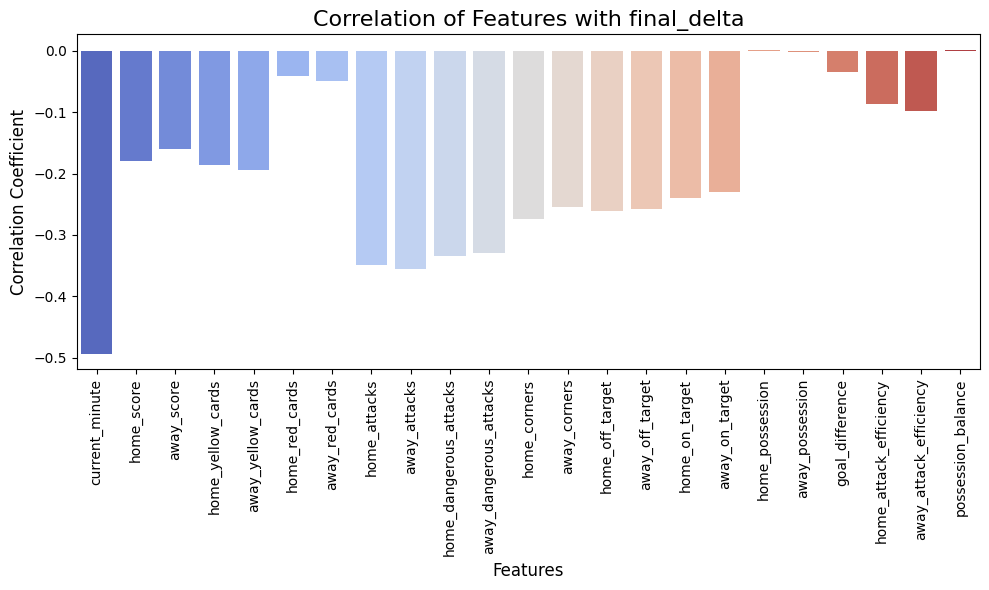

current_minute           -0.493294
home_score               -0.180326
away_score               -0.159346
home_yellow_cards        -0.185480
away_yellow_cards        -0.194211
home_red_cards           -0.041470
away_red_cards           -0.049067
home_attacks             -0.348200
away_attacks             -0.355317
home_dangerous_attacks   -0.334858
away_dangerous_attacks   -0.328723
home_corners             -0.273883
away_corners             -0.254513
home_off_target          -0.261074
away_off_target          -0.257364
home_on_target           -0.239113
away_on_target           -0.230299
home_possession           0.001984
away_possession          -0.002084
goal_difference          -0.035354
home_attack_efficiency   -0.087317
away_attack_efficiency   -0.098888
possession_balance        0.002034
Name: final_delta, dtype: float64


In [67]:
# Calculate correlation of each feature with `final_delta`
correlations = df.corr()['final_delta'].drop('final_delta')

# Plot the correlation graph
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values, palette='coolwarm')

# Add labels and titles

plt.xticks(rotation=90)
plt.title('Correlation of Features with final_delta', fontsize=16)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.tight_layout()

# Show plot
plt.show()
print(correlations)

### Pairwise Correlation of each Feature

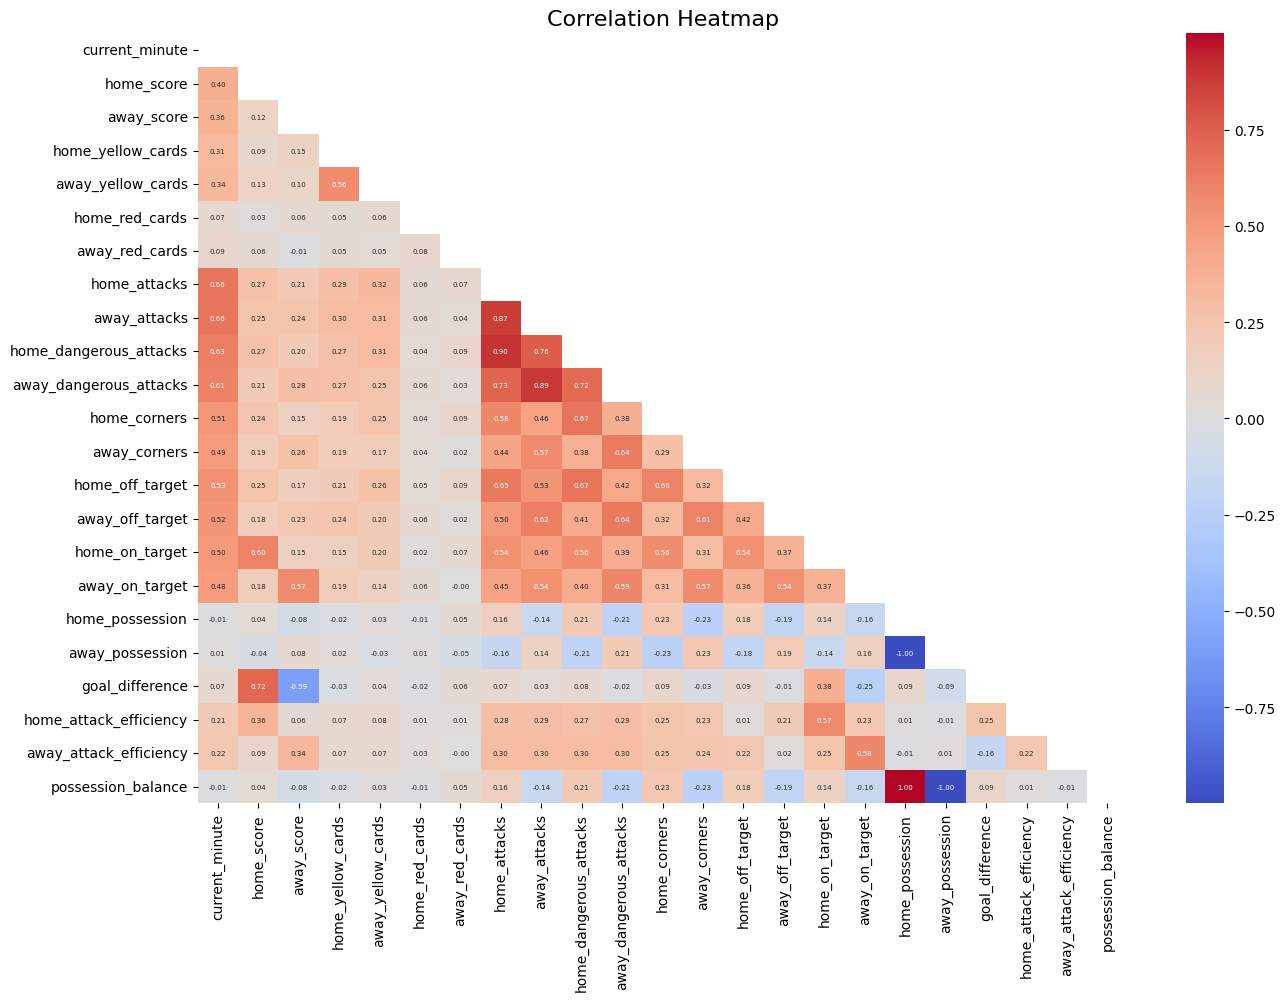

In [68]:
corr_matrix = df.drop('final_delta', axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr_matrix, mask=mask, ax=ax, annot=True, annot_kws={'size': 5}, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

The following pairs of features have high correlation with each other: 
- home_attacks and home_dangerous_attacks (and the away equivalent) - positive 
- home_attacks and away_attacks - positive
- away_corners and possession_balance - negative
- away_corners and possession_balance - negative 

In general, the attack-related features have high positive correlations with each other (a sign we can generalize these as one feature?)

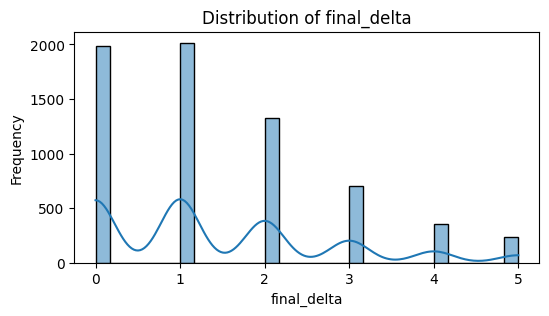

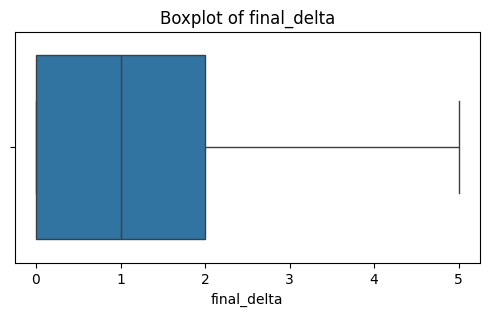

In [69]:
# Visualize distributions using histograms

numerical_cols = ['final_delta']

# Histogram plot
for col in numerical_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

### Boxplot
for col in numerical_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

### Analysis for Attack-related features over Match Time

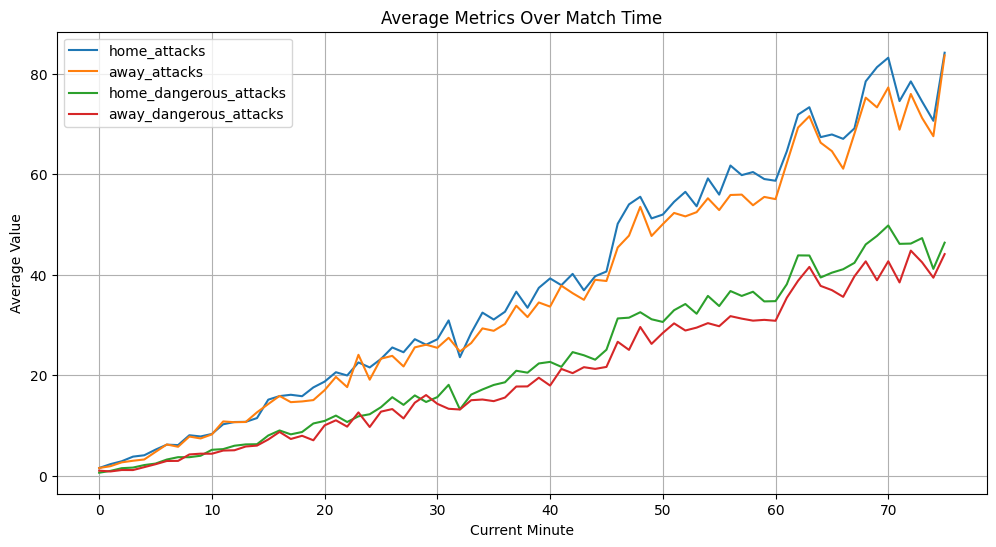

In [70]:
# Group by current_minute and calculate mean values for key metrics
time_analysis = df.groupby('current_minute').mean()
time_metrics = ['home_attacks', 'away_attacks', 'home_dangerous_attacks', 'away_dangerous_attacks']

plt.figure(figsize=(12, 6))
for metric in time_metrics:
    plt.plot(time_analysis.index, time_analysis[metric], label=metric)
plt.title("Average Metrics Over Match Time")
plt.xlabel("Current Minute")
plt.ylabel("Average Value")
plt.legend()
plt.grid()
plt.show()


---

# **Section 6: Initial model training**

In [71]:
X = df.drop("final_delta", axis=1)
y = df['final_delta']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X: (6621, 23)
Shape of y: (6621,)

Shape of X_train: (4634, 23)
Shape of X_test: (1987, 23)


## **Model 1: Linear Regression (order=1)**

In [72]:
# Preprocess LR Model by standardizing features
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# Set up base model 
sgd = SGDRegressor(
    loss="squared_error", 
    penalty='l1', 
    learning_rate='constant',
    random_state=42,
    tol=0.0001, 
    verbose=True,
    )

sgd.fit(X_train_sc, y_train)

-- Epoch 1
Norm: 0.80, NNZs: 23, Bias: 1.437405, T: 4634, Avg. loss: 0.779397
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.41, NNZs: 20, Bias: 1.523821, T: 9268, Avg. loss: 0.765387
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1.89, NNZs: 21, Bias: 1.310213, T: 13902, Avg. loss: 0.755518
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 2.37, NNZs: 23, Bias: 1.402680, T: 18536, Avg. loss: 0.754016
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 2.82, NNZs: 19, Bias: 1.241927, T: 23170, Avg. loss: 0.745463
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 3.35, NNZs: 18, Bias: 1.453045, T: 27804, Avg. loss: 0.745698
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 3.85, NNZs: 15, Bias: 1.349407, T: 32438, Avg. loss: 0.742452
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 4.31, NNZs: 18, Bias: 1.416607, T: 37072, Avg. loss: 0.745351
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 4.74, NNZs: 17, Bias: 1.430600, T: 41706, Avg. loss: 0.734247
Total train

SGDRegressor(learning_rate='constant', penalty='l1', random_state=42,
             tol=0.0001, verbose=True)

In [73]:
weights = pd.DataFrame({
    'Feature': X_train.columns,
    'coef': sgd.coef_
})

weights = pd.concat(
    [weights, pd.DataFrame({'Feature': ['bias'], 
                            'coef':[sgd.intercept_]})],
    ignore_index=True
)

weights = weights.set_index('Feature')
weights

,coef
Feature,
current_minute,-0.657098
home_score,0.107164
away_score,0.0
home_yellow_cards,-0.086114
away_yellow_cards,0.0
home_red_cards,0.0
away_red_cards,-0.031098
home_attacks,0.00958
away_attacks,-0.092897


In [74]:
def ReLU(x):
    return x if x >= 0 else 0

In [75]:
# Get training score 
print("==On training set==\n")
tr_preds = sgd.predict(X_train_sc)
tr_preds = np.round(tr_preds)
tr_preds =  np.maximum(tr_preds, 0)


print(f"Range of predicted values: {np.unique(tr_preds)}" )
rmse = root_mean_squared_error(tr_preds, y_train)
mse = mean_squared_error(tr_preds, y_train)

print(f"RMSE: {rmse:.6f}")
print(f"MSE: {mse:.6f}")

# Get testing score 

print("\n==On test set==\n")
preds = sgd.predict(X_test_sc)
preds = np.round(preds)
preds = np.maximum(preds, 0)

print(f"Range of predicted values: {np.unique(preds)}" )
rmse = root_mean_squared_error(preds, y_test)
mse = mean_squared_error(preds, y_test)
r2 = r2_score(preds, y_test)


print(f"RMSE: {rmse:.6f}")
print(f"MSE: {mse:.6f}")
print(f"R2: {r2:.6f}")

==On training set==

Range of predicted values: [0. 1. 2. 3.]
RMSE: 1.212971
MSE: 1.471299

==On test set==

Range of predicted values: [0. 1. 2. 3.]
RMSE: 1.223614
MSE: 1.497232
R2: -1.381632


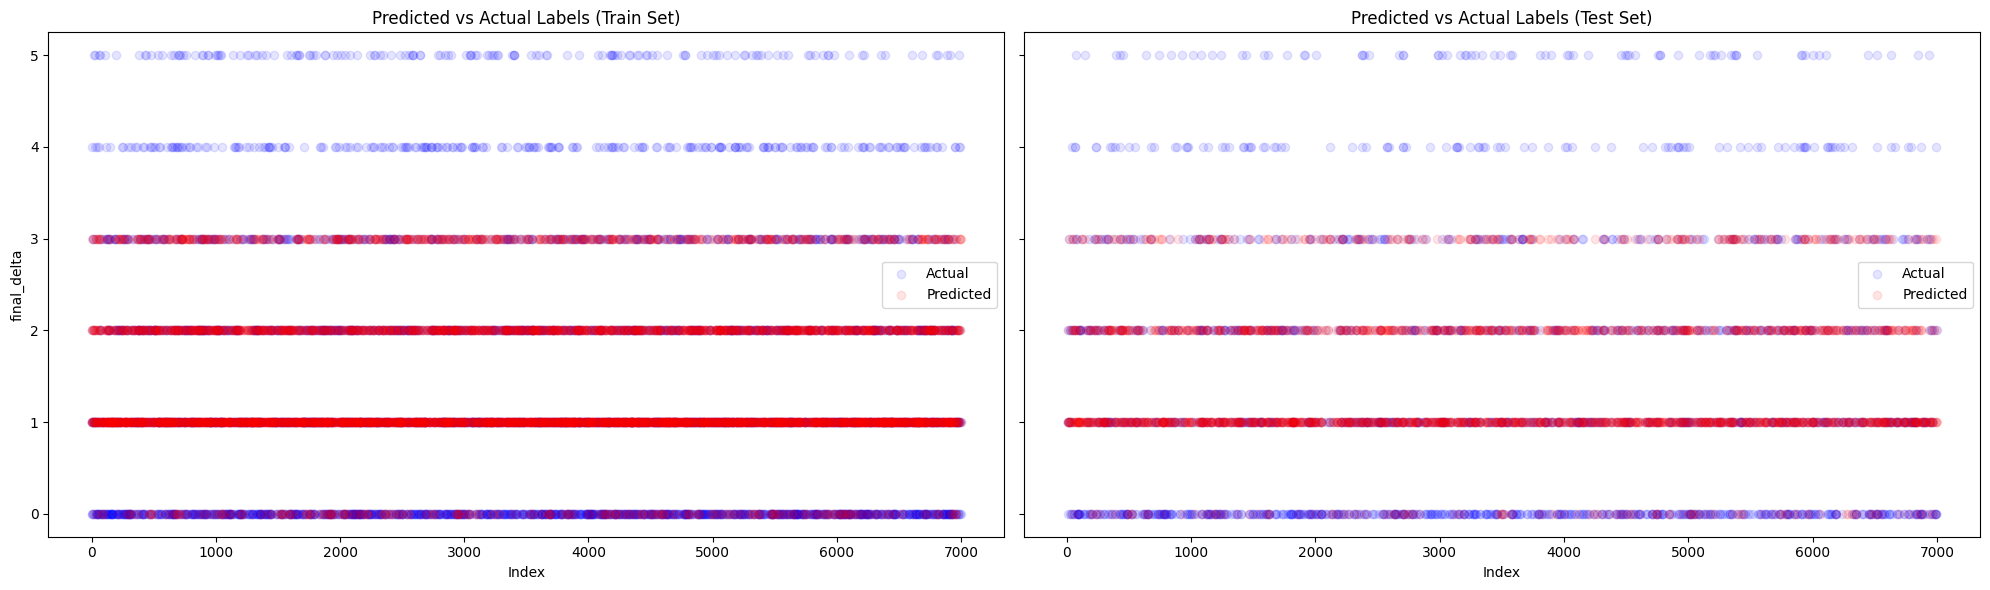

In [76]:
ig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Train set plot
axes[0].scatter(X_train.index, y_train, color='blue', label="Actual", alpha=0.1)
axes[0].scatter(X_train.index, tr_preds, color='red', label="Predicted", alpha=0.1)
axes[0].set_title("Predicted vs Actual Labels (Train Set)")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("final_delta")
axes[0].legend()

# Test set plot
axes[1].scatter(X_test.index, y_test, color='blue', label="Actual", alpha=0.1)
axes[1].scatter(X_test.index, preds, color='red', label="Predicted", alpha=0.1)
axes[1].set_title("Predicted vs Actual Labels (Test Set)")
axes[1].set_xlabel("Index")
axes[1].legend()

plt.tight_layout()
plt.show()

---

## Random Forest

### Initial Model Training

In [77]:
X = df.drop("final_delta", axis=1)
y = df['final_delta']



# df.drop('index', axis=1, inplace=True)
df.head()   
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (6621, 23)
Shape of y: (6621,)


Split the data into training and testing sets

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (4634, 23)
Shape of X_test: (1987, 23)


Random Forest Regressor

In [79]:
# Create the random forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, verbose=True, oob_score=True)

# Fit the model
rf_regressor.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


RandomForestRegressor(oob_score=True, random_state=42, verbose=True)

Evaluating om Training Data and Test Data

In [80]:
# Evaluate on training data
y_train_pred = rf_regressor.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Train MSE: {train_mse}")
print(f"Train RMSE: {train_rmse}")
print(f"Train R²: {train_r2}")

# Evaluate on test data )
y_test_pred = rf_regressor.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R²: {test_r2}")

Train MSE: 0.2254683766754932
Train RMSE: 0.4748351047210949
Train R²: 0.8728062570793442
Test MSE: 1.4752315135906702
Test RMSE: 1.2145910890462972
Test R²: 0.2100198876616981


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


---

### Error Analysis

OOB since we dont want to splut the data further

In [81]:
#visualize the errors (from MSE, RMSE, R2)
# Print train MSE, RMSE, R²
print("Evaluating Training Data Results:")
print(f"Train MSE: {train_mse}")
print(f"Train RMSE: {train_rmse}")
print(f"Train R²: {train_r2}")
print("---------------------------------")

#will use OOB kasi validation set is not necessary since ensemble learning si RF
print("Evaluting Test Data Results:")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R²: {test_r2}")

#regressor
rf_regressor.fit(X_train, y_train)
oob_score = rf_regressor.oob_score_

# OOB Computation
oob_predictions = rf_regressor.oob_prediction_
oob_mse = mean_squared_error(y_train, oob_predictions)
oob_rmse = np.sqrt(oob_mse)
oob_r2 = r2_score(y_train, oob_predictions)
print("---------------------------------")
print("Evaluting Out-Of-Bag(OOB) Data Results:")
print(f"OOB MSE: {oob_mse}")
print(f"OOB RMSE: {oob_rmse}")
print(f"OOB R²: {oob_r2}")
print(f"\nOOB Score: {oob_score}")

#residual plot

#actual vs predicted plot

Evaluating Training Data Results:
Train MSE: 0.2254683766754932
Train RMSE: 0.4748351047210949
Train R²: 0.8728062570793442
---------------------------------
Evaluting Test Data Results:
Test MSE: 1.4752315135906702
Test RMSE: 1.2145910890462972
Test R²: 0.2100198876616981


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


---------------------------------
Evaluting Out-Of-Bag(OOB) Data Results:
OOB MSE: 1.4403346510039128
OOB RMSE: 1.2001394298180161
OOB R²: 0.18746230393463048

OOB Score: 0.18746230393463048


Analyzing Feature Importances

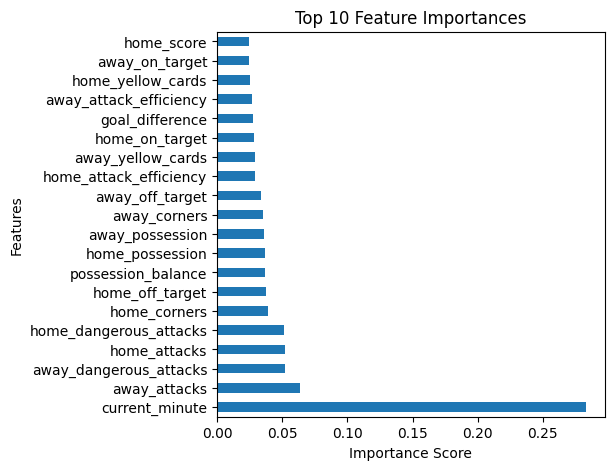

current_minute            0.283269
away_attacks              0.063285
away_dangerous_attacks    0.052001
home_attacks              0.051820
home_dangerous_attacks    0.051620
home_corners              0.039074
home_off_target           0.037194
possession_balance        0.036862
home_possession           0.036602
away_possession           0.036302
away_corners              0.035203
away_off_target           0.033576
home_attack_efficiency    0.029346
away_yellow_cards         0.028873
home_on_target            0.028493
goal_difference           0.027662
away_attack_efficiency    0.026650
home_yellow_cards         0.025459
away_on_target            0.024776
home_score                0.024489
away_score                0.022907
away_red_cards            0.002390
home_red_cards            0.002145
dtype: float64


In [82]:
#identify difficult to predict data points
#feature importance
plt.figure()
# Applying the ExtraTreesRegressor for feature importance
model = ExtraTreesRegressor()
model.fit(X, y)

# Extracting feature importances
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

# Plotting the top 10 important features
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Displaying the feature importances for reference
print(feat_importances.sort_values(ascending=False))

Bias Variance Analysis? -- idk why but

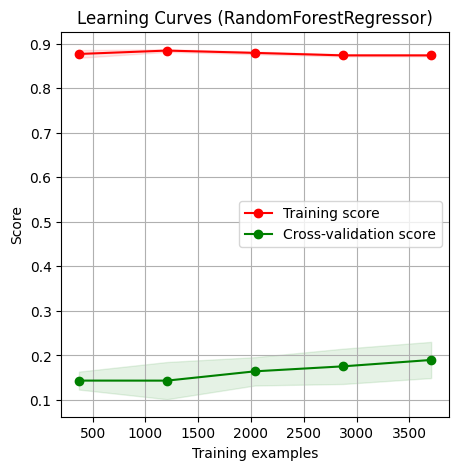

In [83]:
from random_forest_util import plot_learning_curve
# Initialize your model
rf_regressor = RandomForestRegressor(random_state=42)

# Plot learning curve for RandomForestRegressor
plot_learning_curve(rf_regressor, "Learning Curves (RandomForestRegressor)", X_train, y_train, cv=5, n_jobs=-1)
plt.show()

---

### Improving Model Performance

Feature Engineering

Time-based Features

In [84]:
# Adjust for Halftime
df['normalized_time'] = df['current_minute'].apply(lambda x: x if x <= 45 else (x - 15 if x > 60 else 45))

# Create Time-Based Features
df['is_second_half'] = df['normalized_time'] > 45


Bin minutes

In [85]:
# # Bin the adjusted_minute into categories
# bins = [0, 15, 30, 45, 60, 75, 90]
# labels = ['0-15', '15-30', '30-45', '45-60', '60-75', '75-90']
# df['binned_minute'] = pd.cut(df['current_minute'], bins=bins, labels=labels, right=False)

# # Display the first few rows to verify the new feature
# df[['current_minute', 'binned_minute']].head()

In [86]:
# Convert categorical features to numeric using one-hot encoding
df = pd.get_dummies(df, drop_first=True)

# Display the first few rows to verify the changes
df.head()

,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,...,away_on_target,home_possession,away_possession,final_delta,goal_difference,home_attack_efficiency,away_attack_efficiency,possession_balance,normalized_time,is_second_half
0,64,1,2,0,0,0,0,39,45,29,...,6,48,52,1,-1,0.499999,0.999998,-4,49,True
1,61,2,0,0,0,0,0,0,0,0,...,0,50,50,1,2,0.000000,0.000000,0,46,True
2,3,0,0,0,0,0,0,3,1,1,...,0,62,38,4,0,0.000000,0.000000,24,3,False
3,17,0,0,1,0,0,0,41,46,11,...,0,55,45,2,0,0.000000,0.000000,10,17,False
4,46,1,0,1,0,0,0,69,78,21,...,4,45,55,0,1,0.999998,0.571428,-10,45,False


Interaction Features

In [87]:
# Feature Engineering: Interaction Features

# Calculate attack_ratio
df['attack_ratio'] = df['home_attacks'] / (df['away_attacks'] + 1e-5)

# Calculate possession_difference
df['possession_difference'] = df['home_possession'] - df['away_possession']

# Calculate score_difference
df['score_difference'] = df['home_score'] - df['away_score']

# Calculate time-based interaction features
df['time_home_attacks_interaction'] = df['normalized_time'] * df['home_attacks']
df['time_away_attacks_interaction'] = df['normalized_time'] * df['away_attacks']

# Fourier Transform for cyclical nature of time
# df['sin_time'] = np.sin(df['current_minute'] * 2 * np.pi / 105)
# df['cos_time'] = np.cos(df['current_minute'] * 2 * np.pi / 105)

# Additional Interaction Features
# df['attack_ratio'] = df['home_attacks'] / (df['away_attacks'] + 1e-5)
# df['possession_difference'] = df['home_possession'] - df['away_possession']
df['score_difference'] = df['home_score'] - df['away_score']

# Recent Performance Features
# df['recent_home_attacks'] = df['home_attacks'].rolling(window=5, min_periods=1).mean()
# df['recent_away_attacks'] = df['away_attacks'].rolling(window=5, min_periods=1).mean()
# df['recent_home_corners'] = df['home_corners'].rolling(window=5, min_periods=1).mean()
# df['recent_away_corners'] = df['away_corners'].rolling(window=5, min_periods=1).mean()
# df['recent_home_shots'] = df['home_on_target'].rolling(window=5, min_periods=1).mean()
# df['recent_away_shots'] = df['away_on_target'].rolling(window=5, min_periods=1).mean()

# Display the first few rows to verify the new features
# df[['home_attacks', 'away_attacks', 'attack_ratio', 'home_possession', 'away_possession', 'possession_difference', 'home_score', 'away_score', 'score_difference', 'time_home_attacks_interaction', 'time_away_attacks_interaction', 'sin_time', 'cos_time', 'recent_home_attacks', 'recent_away_attacks', 'recent_home_corners', 'recent_away_corners', 'recent_home_shots', 'recent_away_shots',]].head()

Momentum Features

Categorical Features

In [88]:
# Feature Engineering: Convert meaningful numeric variables into categories

# Create a binary indicator for home advantage
# df['home_advantage'] = (df['home_possession'] > df['away_possession']).astype(int)

# Display the first few rows to verify the new feature
# df[['home_possession', 'away_possession', 'home_advantage']].head()
X = df.copy()
X = X.drop("final_delta", axis=1)
print(X.columns)


Index(['current_minute', 'home_score', 'away_score', 'home_yellow_cards',
       'away_yellow_cards', 'home_red_cards', 'away_red_cards', 'home_attacks',
       'away_attacks', 'home_dangerous_attacks', 'away_dangerous_attacks',
       'home_corners', 'away_corners', 'home_off_target', 'away_off_target',
       'home_on_target', 'away_on_target', 'home_possession',
       'away_possession', 'goal_difference', 'home_attack_efficiency',
       'away_attack_efficiency', 'possession_balance', 'normalized_time',
       'is_second_half', 'attack_ratio', 'possession_difference',
       'score_difference', 'time_home_attacks_interaction',
       'time_away_attacks_interaction'],
      dtype='object')


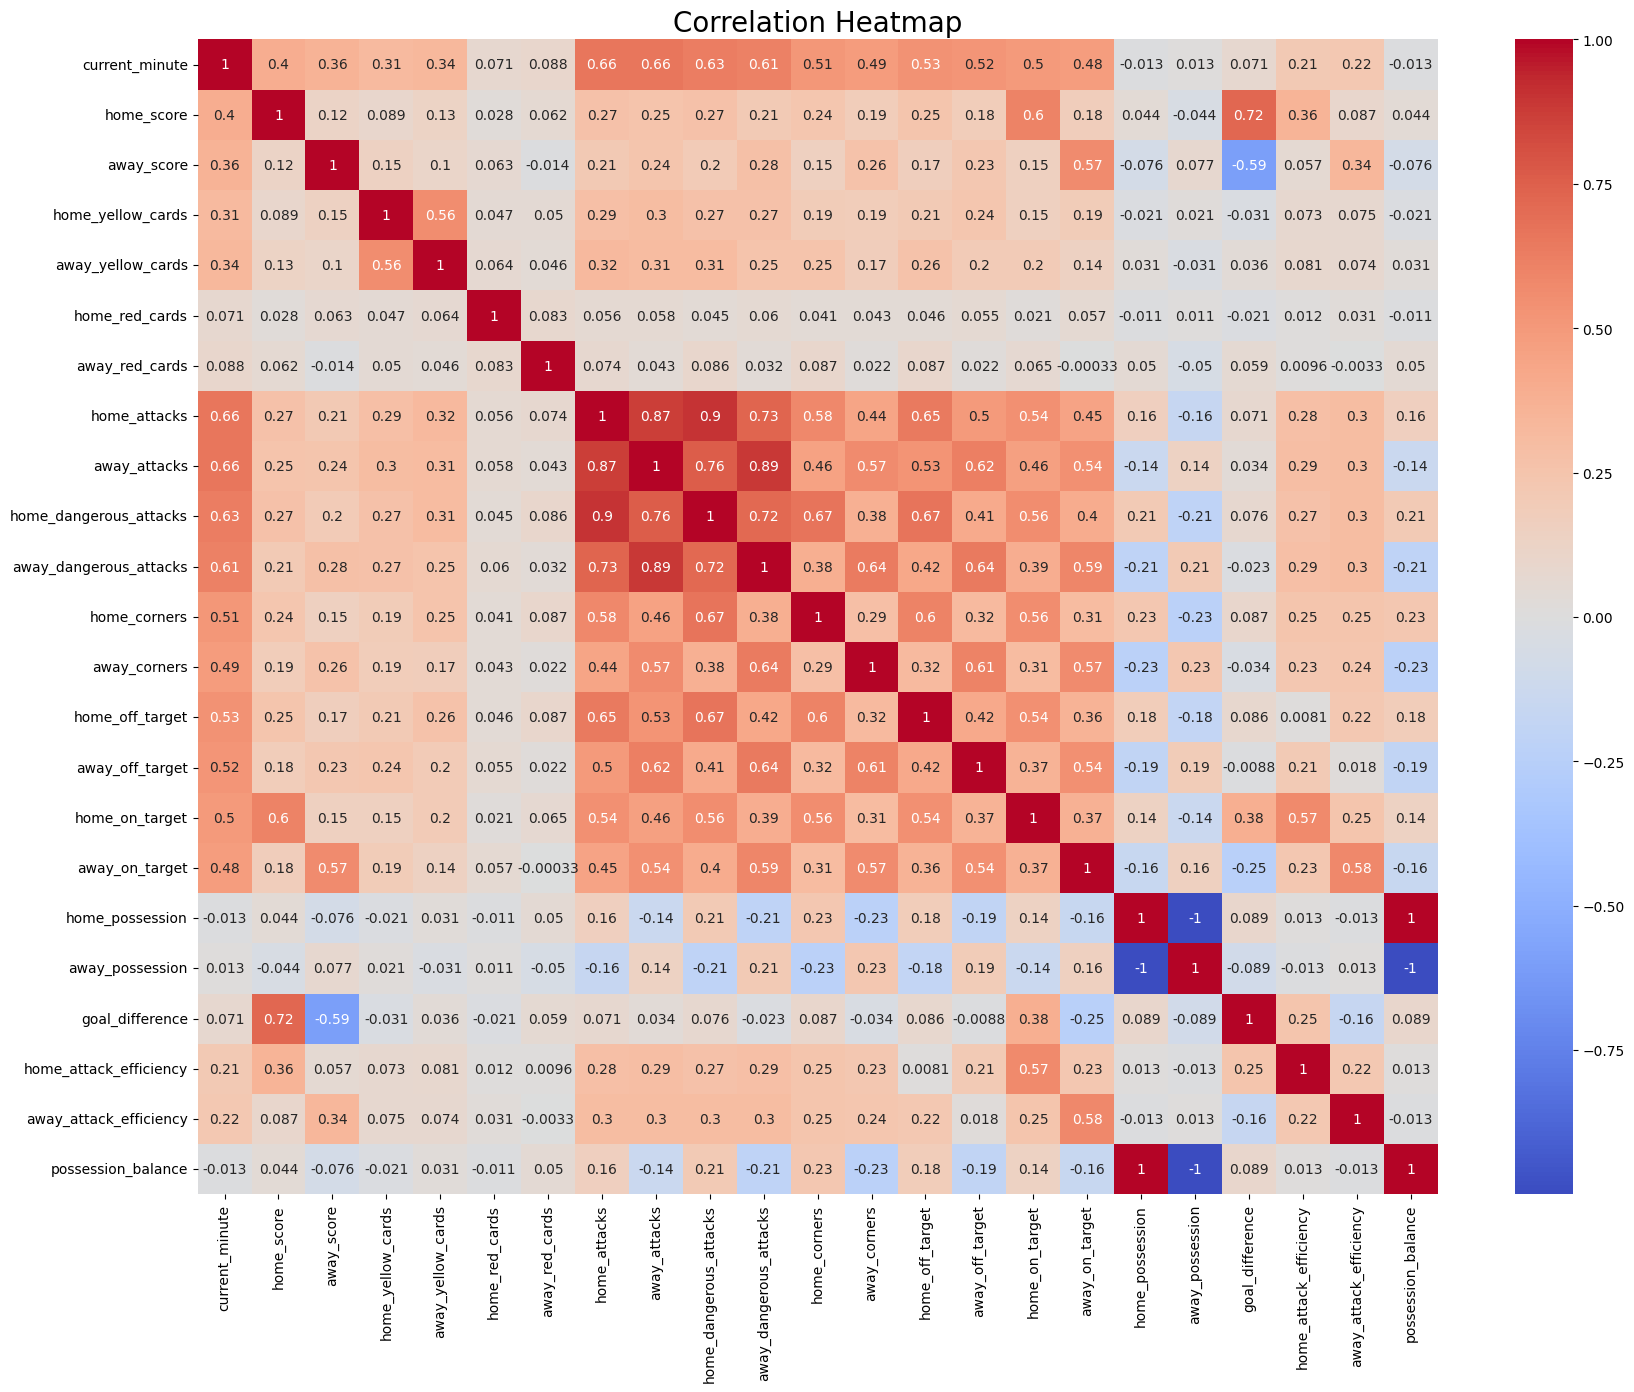

In [89]:
# Convert categorical features to numeric using one-hot encoding
# X_numeric = pd.get_dummies(X, drop_first=True)

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=20)
plt.show()


Drop Low Important Features

Shape of X after dropping low correlation features: (6621, 19)
Columns dropped due to low correlation: ['home_red_cards', 'away_red_cards', 'home_possession', 'away_possession', 'goal_difference', 'home_attack_efficiency', 'away_attack_efficiency', 'possession_balance', 'attack_ratio', 'possession_difference', 'score_difference']


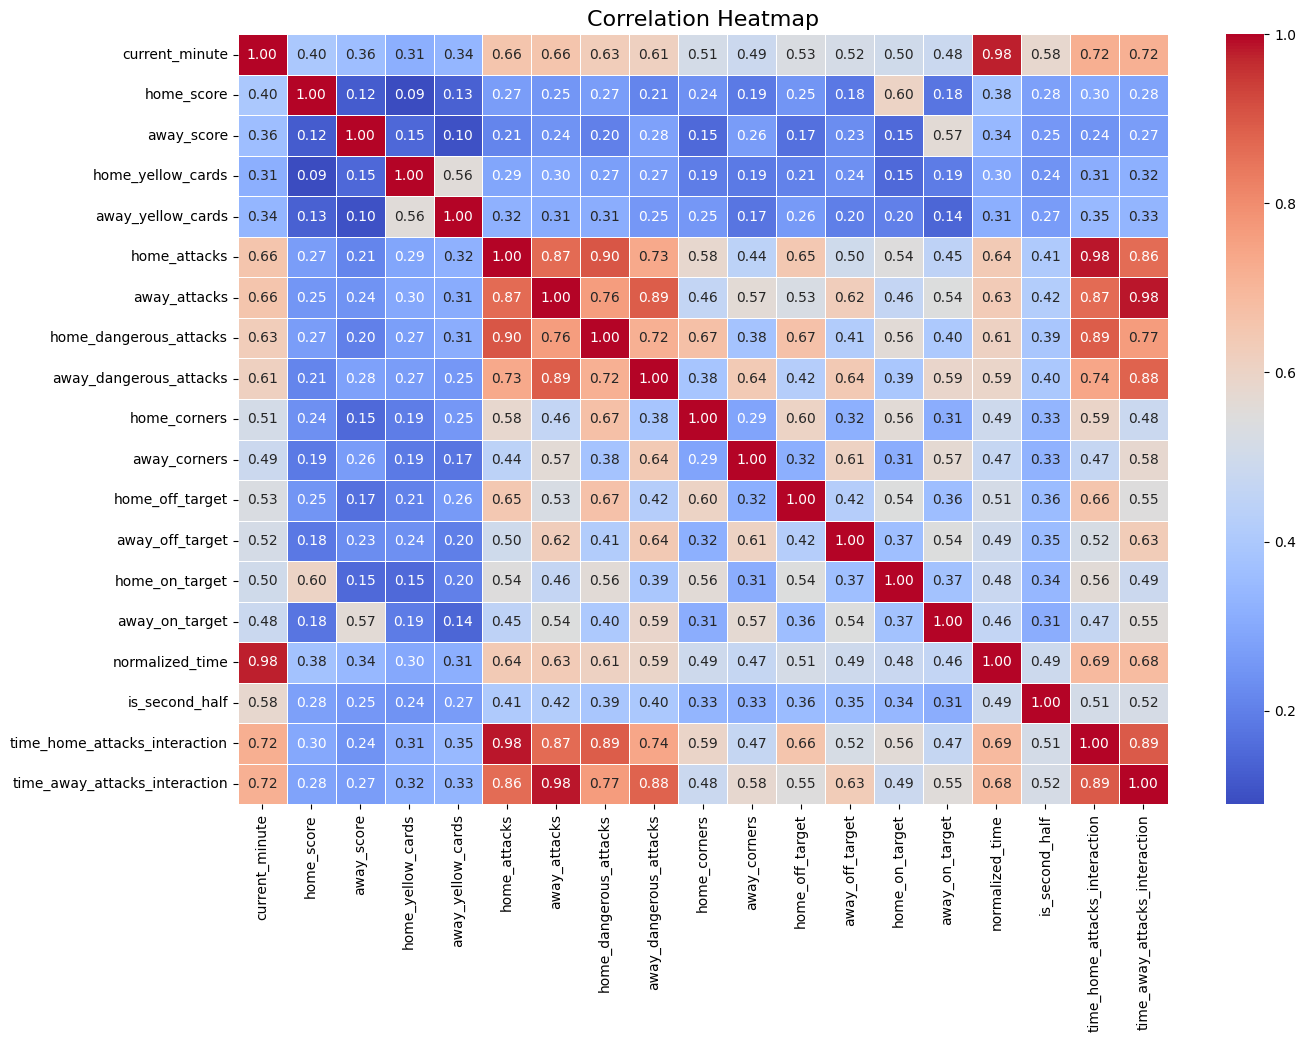

In [90]:
X['final_delta'] = y

correlations = X.corr()['final_delta'].drop('final_delta')

correlation_threshold = 0.1

# Identify features with low correlation
low_correlation_features = correlations[abs(correlations) < correlation_threshold].index.tolist()

#check in the data is in there
existing_features_to_drop = [feature for feature in low_correlation_features if feature in X.columns]

# Drop low correlation features
X = X.drop(columns=existing_features_to_drop)

# Drop 'final_delta' from the features
X= X.drop(columns=['final_delta'])

print(f"Shape of X after dropping low correlation features: {X.shape}")
print(f"Columns dropped due to low correlation: {existing_features_to_drop}")

# Improved correlation heatmap
plt.figure(figsize=(15, 10))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

In [91]:
# Print all column headers
print(df.columns)
print(X.columns)
print(X.columns)

Index(['current_minute', 'home_score', 'away_score', 'home_yellow_cards',
       'away_yellow_cards', 'home_red_cards', 'away_red_cards', 'home_attacks',
       'away_attacks', 'home_dangerous_attacks', 'away_dangerous_attacks',
       'home_corners', 'away_corners', 'home_off_target', 'away_off_target',
       'home_on_target', 'away_on_target', 'home_possession',
       'away_possession', 'final_delta', 'goal_difference',
       'home_attack_efficiency', 'away_attack_efficiency',
       'possession_balance', 'normalized_time', 'is_second_half',
       'attack_ratio', 'possession_difference', 'score_difference',
       'time_home_attacks_interaction', 'time_away_attacks_interaction'],
      dtype='object')
Index(['current_minute', 'home_score', 'away_score', 'home_yellow_cards',
       'away_yellow_cards', 'home_attacks', 'away_attacks',
       'home_dangerous_attacks', 'away_dangerous_attacks', 'home_corners',
       'away_corners', 'home_off_target', 'away_off_target', 'home_on_targ

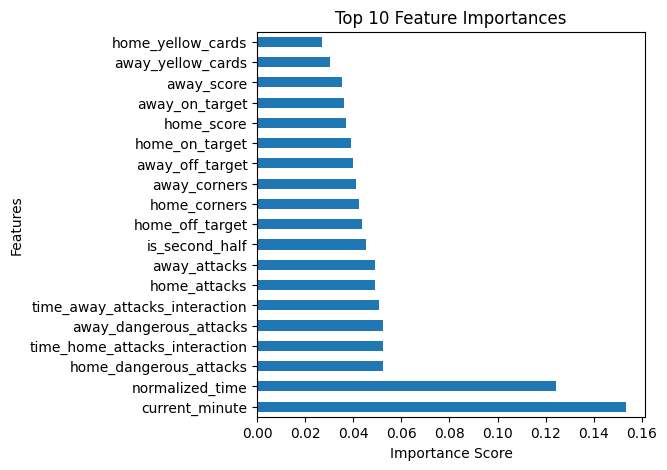

current_minute                   0.153607
normalized_time                  0.124175
home_dangerous_attacks           0.052402
time_home_attacks_interaction    0.052220
away_dangerous_attacks           0.052179
time_away_attacks_interaction    0.050666
home_attacks                     0.049163
away_attacks                     0.048928
is_second_half                   0.045352
home_off_target                  0.043572
home_corners                     0.042305
away_corners                     0.041210
away_off_target                  0.039860
home_on_target                   0.039054
home_score                       0.037019
away_on_target                   0.035946
away_score                       0.035291
away_yellow_cards                0.030273
home_yellow_cards                0.026778
dtype: float64


In [92]:
#identify difficult to predict data points
#feature importance
plt.figure()
# Applying the ExtraTreesRegressor for feature importance
model = ExtraTreesRegressor()
model.fit(X, y)

# Extracting feature importances
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

# Plotting the top 10 important features
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Displaying the feature importances for reference
print(feat_importances.sort_values(ascending=False))

Retraining the model with the feature Engineered features (word better nyahaha)

In [93]:
# Update the feature set
X = df.drop("final_delta", axis=1)
y = df['final_delta']

# Convert categorical features to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, verbose=True, oob_score=True)
rf_regressor.fit(X_train, y_train)

# Evaluate the model
y_train_pred = rf_regressor.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = rf_regressor.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse}")
print(f"Train RMSE: {train_rmse}")
print(f"Train R²: {train_r2}")
print("---------------------------------")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R²: {test_r2}")

Shape of X: (6621, 30)
Shape of y: (6621,)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


Train MSE: 0.2269575823239393
Train RMSE: 0.47640065315230135
Train R²: 0.8719661497294915
---------------------------------
Test MSE: 1.4626030489136732
Test RMSE: 1.2093812669764954
Test R²: 0.21678237602524475


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Feature Importances

In [94]:


# Feature importance
importances = rf_regressor.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
feature_names = X.columns

print("Feature Importances:")
print("---------------------------------")

for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")
print("---------------------------------")


Feature Importances:
---------------------------------
current_minute: 0.2075348366187855
normalized_time: 0.10596418421072692
attack_ratio: 0.06501250284073992
home_dangerous_attacks: 0.04770313903746802
away_dangerous_attacks: 0.04737468598761408
time_away_attacks_interaction: 0.04488018738498881
time_home_attacks_interaction: 0.04482989443800238
away_attacks: 0.034720381047209696
home_attacks: 0.032542562561581743
home_attack_efficiency: 0.03240241789800262
away_attack_efficiency: 0.029302040210688787
home_corners: 0.02653309387803382
away_corners: 0.024289070386252387
home_off_target: 0.023531505654605926
away_off_target: 0.02299381095991238
possession_balance: 0.021300450388169846
home_possession: 0.020747901589788773
possession_difference: 0.02009516156429779
away_possession: 0.019773951230653553
home_on_target: 0.017190751810086388
away_yellow_cards: 0.016180326608642936
home_yellow_cards: 0.016023498777656145
score_difference: 0.01566730818636803
goal_difference: 0.014818453479

In [95]:
# Ensure feature_names corresponds to the training data
feature_names = X_train.columns  # Assuming X_train is a pandas DataFrame
print("---------------------------------")

# Fit the model
rf_regressor.fit(X_train, y_train)

# Get feature importances
importances = rf_regressor.feature_importances_

# Sort indices based on importances
sorted_indices = np.argsort(importances)[::-1]

# Display sorted feature importances
print("Feature Importances:")
print("---------------------------------")

for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")
print("---------------------------------")


---------------------------------


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s


Feature Importances:
---------------------------------
current_minute: 0.2075348366187855
normalized_time: 0.10596418421072692
attack_ratio: 0.06501250284073992
home_dangerous_attacks: 0.04770313903746802
away_dangerous_attacks: 0.04737468598761408
time_away_attacks_interaction: 0.04488018738498881
time_home_attacks_interaction: 0.04482989443800238
away_attacks: 0.034720381047209696
home_attacks: 0.032542562561581743
home_attack_efficiency: 0.03240241789800262
away_attack_efficiency: 0.029302040210688787
home_corners: 0.02653309387803382
away_corners: 0.024289070386252387
home_off_target: 0.023531505654605926
away_off_target: 0.02299381095991238
possession_balance: 0.021300450388169846
home_possession: 0.020747901589788773
possession_difference: 0.02009516156429779
away_possession: 0.019773951230653553
home_on_target: 0.017190751810086388
away_yellow_cards: 0.016180326608642936
home_yellow_cards: 0.016023498777656145
score_difference: 0.01566730818636803
goal_difference: 0.014818453479

Hyperparameter Tuning (using Exhaustive Search)

In [96]:
best_rf_model = tune_random_forest(X_train, y_train, X_test, y_test)



Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bo

---

# **Section 11: References**



> Dump Ref muna fix it later

https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2019.00501/full

https://www.sciencedirect.com/science/article/abs/pii/S0169207018300116

https://warin.ca/ressources/books/2013_Book_AppliedPredictiveModeling.pdf

https://ieeexplore.ieee.org/document/4160265

https://www.researchgate.net/publication/265194455_pandas_a_Foundational_Python_Library_for_Data_Analysis_and_Statistics

https://web.mit.edu/dvp/Public/numpybook.pdf

https://dl.acm.org/doi/10.5555/1953048.2078195

https://www.researchgate.net/publication/350701622_seaborn_statistical_data_visualization

https://www.sciencedirect.com/book/9780123814791/data-mining-concepts-and-techniques

https://archive.org/details/exploratorydataa0000tuke_7616

---

- Anguera, M. T., Blanco-Villaseñor, A., Losada, J. L., & Perea, M. V. (2018). Sports analysis and prediction: New challenges and approaches. Frontiers in Psychology, 10, 501. https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2019.00501/full

- Yin, D., & Leong, S. Y. (2017). Predictive modeling in soccer analytics. International Journal of Sports Management and Marketing, 7(3), 235-248. https://www.sciencedirect.com/science/article/abs/pii/S0169207018300116

- Kuhn, M., & Johnson, K. (2013). Applied predictive modeling. Springer Science & Business Media. https://warin.ca/ressources/books/2013_Book_AppliedPredictiveModeling.pdf

- Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. https://ieeexplore.ieee.org/document/4160265

- McKinney, W. (2011). pandas: A foundational Python library for data analysis and manipulation. Python for Data Analysis, O'Reilly Media. https://www.researchgate.net/publication/265194455_pandas_a_Foundational_Python_Library_for_Data_Analysis_and_Statistics

- Oliphant, T. E. (2006). A guide to NumPy. Trelgol Publishing. https://web.mit.edu/dvp/Public/numpybook.pdf

- Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830. https://dl.acm.org/doi/10.5555/1953048.2078195

- Waskom, M. L. (2021). Seaborn: Statistical data visualization. Journal of Open Source Software, 6(60), 3021. https://www.researchgate.net/publication/350701622_seaborn_statistical_data_visualization

- Han, J., Kamber, M., & Pei, J. (2011). Data mining: Concepts and techniques. Elsevier. https://www.sciencedirect.com/book/9780123814791/data-mining-concepts-and-techniques

- Tukey, J. W. (1977). Exploratory data analysis. Addison-Wesley. https://archive.org/details/exploratorydataa0000tuke_7616